# Running NetLogo BehaviorSpace Experiments within a Jupyter Notebook

This notebook demonstrates how to define a BehaviorSpace experiment by generating an XML document and passing it to NetLogo's headless mode through the `--setup-file` argument.

This approach may be useful for a couple of cases:

* You are planning to publish reproducible supplemental materials for a publication.
* You are working on a new model and you would like to generate some preliminary data for exploratory analysis.

If you would like to read more about Behaviorspace, visit:

* https://ccl.northwestern.edu/netlogo/docs/behaviorspace.html 

If you would like to review the XML setup file format, visit: 

* https://ccl.northwestern.edu/netlogo/docs/behaviorspace.html#advanced-usage

If you have any questions or suggestions, send me an email at umitaslan@u.northwestern.edu.

## 0. Import libraries, download the model, & download NetLogo

This step may not be needed for local installations. You can simply copy the NetLogo folder and your model within the same folder of this notebook, and make sure the values of the `MODEL_NAME` and `NETLOGO_FOLDER` variables match your local files. 

Google Colab removes files within the session storage once the user disconnects, so it is necessary to download the files from scratch every time we run this notebook. It is also a nice demo, and may be necessary if you are sharing your work with those who are familiar with Python but not NetLogo.

Here is what the code below does:

* Check if the model file exists. If not, download it from the link specified with the `MODEL_LINK` variable.
* Check if a NetLogo installation specified in the `NETLOGO_FOLDER` variable exists. If not, download it from http://ccl.northwestern.edu/netlogo/ and unpack within the folder.

_Note: This script downloads Linux 64-bit version of NetLogo, which should run just fine on any MacOS and Linux machine as the `netlogo-headless.sh` script runs NetLogo as a cross-platform Java application. However, it will not run on Windows machines because the Windows package comes with a `*.bat` script. If you are planning to run this script on your Windows machine, I recommend you to run it through the Windows Subsystem for Linux._

In [1]:
from pathlib import Path
import urllib.request
from dataclasses import dataclass, field
from typing import Dict, Tuple
import xml.etree.ElementTree as et
import pandas as pd

In [ ]:
MODEL_NAME = 'fire'
NETLOGO_FOLDER = 'netlogo'

In [18]:
## Check if NetLogo is installed, if not download and extract it

if not Path(NETLOGO_FOLDER, 'netlogo-headless.sh').is_file():
  print("Could not find NetLogo headless, I'll attempt to download it now.")

  urllib.request.urlretrieve('https://ccl.northwestern.edu/netlogo/7.0.0/NetLogo-7.0.0-64.tgz', 'netlogo.tgz')

  !tar -xf netlogo.tgz
  !mv NetLogo\ 7.0.0 {NETLOGO_FOLDER}
  !rm netlogo.tgz

  if Path(NETLOGO_FOLDER, 'netlogo-headless.sh').is_file():
    print("✅ Done! If you did not see any errors above, it all went well.")
  else:
    print("😵 Something went wrong, could not download NetLogo!")
else:
  print("👍🏼 NetLogo found.")


## Check if the Fire model file is present, if not download it

if not Path(f'{MODEL_NAME}.nlogox').is_file():
  print("Could not find the model file. I'll attempt to download it now.")
  urllib.request.urlretrieve('http://ccl.northwestern.edu/netlogo/models/models/Sample%20Models/Earth%20Science/Fire.nlogox', f'{MODEL_NAME}.nlogox')

  if Path(f'{MODEL_NAME}.nlogox').is_file():
    print("✅ Successfully downloaded the model file.")
  else:
    print("😵 Something went wrong, could not download the model file.")

else:
  print("👍🏼 Model file found.")

👍🏼 NetLogo found.
👍🏼 Model file found.


## 1. Define a class to map python objects to an XML setup file & run experiments

The `BehaviorSpaceExperiment` class allows defining experiments within the notebook that can later be parsed to XML by the following `run_behaviorspace_experiment` function.

* `name`: The name of the experiment as `string`.
  * Default: `"my experiment"`
* `repetitions`: Number of runs as `integer`.
  * Default: `1`
* `steps`: Number of ticks each repetition should run as `integer`.
  * Default: `1000`
* `every_step`: Whether the experiment should record the provided metrics after each tick, either `true` or `false`.
  * Default: `false`
* `setup`: NetLogo code that should be executed at the beginning of each repetition as `string`. 
  * Default: `"setup"`
* `go`: NetLogo code that should be executed at each tick of a repetition as `string`. 
  * Default: `"go"`
* `final`: NetLogo code that should be executed at the end of each repetition as `string`.
  * Default: `""`
* `metrics`: Variables that should be recorded in the output table as columns as a `tuple` of `string` values. 
  * Default: `("count turtles", "count patches")`
* `enumerated_values`: Model parameters passed as single values as a `dictionary` of `string:list(string)` pairs.
  * Default: _empty_
  * Example: `{"density":["10", "40", "60"], "burned-trees":["100"]}`
* `stepped_values`: Model parameters passed as ranges as a `dictionary` of `string:tuple(start, step, end)` pairs. Note that even integer values should be added as string.
  * Default: _empty_
  * Example: `{"density":(10, 1, 90)}`




In [4]:
@dataclass
class BehaviorSpaceExperiment:

    name:str = "my experiment"
    repetitions:int = 1

    steps:int = 1000
    every_step:bool = False

    setup:str = "setup"
    go:str = "go"
    exit:str = ""
    final:str = ""
    
    metrics:tuple = ("count turtles", "count patches")

    enumerated_values:dict[str, list] = field(default_factory=dict)  
    stepped_values:dict[str,Tuple] = field(default_factory=dict)  

    
    @property
    def XML_PATH(self):
        return Path(f'output', 'xml') / f"{self.name}.xml"
    
    @property
    def CSV_PATH(self):
        return Path(f'output', 'csv') / f"{self.name}.csv"

    def run(self):
        root = et.Element("experiments")

        xml = et.SubElement(root, "experiment",
                            name=self.name,
                            repetitions=str(self.repetitions),
                            runMetricsEveryStep=str(self.every_step).lower())

        # note: Behaviorspace expects elements in the following order: 
        #       setup?,go?,final?,timeLimit?,exitCondition?,metric*,(steppedValueSet|enumeratedValueSet)*

        et.SubElement(xml, "setup").text = self.setup
        et.SubElement(xml, "go").text = self.go

        if len(self.final) > 0:
            et.SubElement(xml, "final").text = self.final

        et.SubElement(xml, "timeLimit", steps=str(self.steps))

        if len(self.exit) > 0:
            et.SubElement(xml, "exitCondition").text = self.exit

        for m in self.metrics:
            et.SubElement(xml, "metric").text = m

        for ev in self.enumerated_values:
            sub_el = et.SubElement(xml, "enumeratedValueSet", variable=ev)
            for v in self.enumerated_values[ev]:
                et.SubElement(sub_el, "value", value=v)

        for sv in self.stepped_values:
            sub_el = et.SubElement(xml, 
                                   "steppedValueSet", 
                                   variable=sv, 
                                   first=str(self.stepped_values[sv][0]), 
                                   step=str(self.stepped_values[sv][1]), 
                                   last=str(self.stepped_values[sv][2]))

        tree = et.ElementTree(root)

        Path(f'output', 'xml').mkdir(parents=True, exist_ok=True)
        Path(f'output', 'csv').mkdir(parents=True, exist_ok=True)

        if self.XML_PATH.is_file(): self.XML_PATH.unlink(missing_ok=True)
        if self.CSV_PATH.is_file(): self.CSV_PATH.unlink(missing_ok=True)

        with open(self.XML_PATH, "wb") as f:
            f.write('<?xml version="1.0" encoding="UTF-8"?><!DOCTYPE experiments SYSTEM "behaviorspace.dtd">'.encode("utf-8"))
            tree.write(f, encoding="utf-8")

        print("Firing up NetLogo.")
        !./{NETLOGO_FOLDER}/netlogo-headless.sh --model {MODEL_NAME}.nlogox --setup-file {self.XML_PATH} --table {self.CSV_PATH}

        return "ALL DONE."


## 3. Create an experiment


In [5]:
# Define the experiment

e_01 = BehaviorSpaceExperiment()
e_01.name = "fire-experiment"
e_01.repetitions = 3
e_01.every_step = False
e_01.steps = 1000

e_01.metrics = ('burned-trees', 'initial-trees')

e_01.stepped_values = {"density":(0, 1, 100)}

e_01.setup = 'setup'
e_01.go = 'go'
e_01.final = 'if behaviorspace-run-number mod 30 = 0 [ show (word ((behaviorspace-run-number / 300) * 100) "% finished.")]'

### 3.1. Run the experiment

In [6]:
e_01.run()

Firing up NetLogo.
JAVA_HOME undefined, using java from path. For control over exact java version, set JAVA_HOME
observer: "10% finished."
observer: "20% finished."
observer: "30% finished."
observer: "40% finished."
observer: "50% finished."
observer: "60% finished."
observer: "70% finished."
observer: "80% finished."
observer: "90% finished."
observer: "100% finished."


'ALL DONE.'

## 4. Load the output & analyze with python libraries

Once we have a csv file, we can import it using the `pandas` library (or other python libraries) and then carry out manipulation, analysis, and visualization tasks.

Notice the `skiprows=6` parameter below. We need to use this parameter because the first 6 rows of the table output includes a hearder section. 

Visit the following page to learn more about BehaviorSpace output formats:

* https://ccl.northwestern.edu/netlogo/docs/behaviorspace.html#run-options-formats .

This notebook uses `pandas` for data manipulation and analysis. Here's a good `pandas` tutorial for beginners:

* https://realpython.com/pandas-python-explore-dataset/#visualizing-your-pandas-dataframe

### 4.1. Load the spreadsheet

In [7]:
pd.set_option("display.precision", 2)
df = pd.read_csv(e_01.CSV_PATH, skiprows=6)

#### Example: Sample some rows

In [8]:
df.sample(5)

,[run number],density,[step],burned-trees,initial-trees
154,155,51,59,970,31899
172,176,58,78,2292,36404
198,199,66,383,39912,41532
93,94,31,21,148,19455
130,123,40,38,319,25057


#### Example: Generate a new column 

In [9]:
df['percent-burned'] = (df['burned-trees'] / df['initial-trees']) * 100

In [10]:
df.sample(5)

,[run number],density,[step],burned-trees,initial-trees,percent-burned
22,23,7,14,16,4301,0.37
152,154,51,31,559,32081,1.74
15,14,4,13,7,2636,0.27
87,90,29,19,152,18199,0.84
57,61,20,17,69,12741,0.54


#### Example: Descriptive statistics

In [11]:
df.describe()

,[run number],density,[step],burned-trees,initial-trees,percent-burned
count,303.00,303.0,303.00,303.00,303.00,300.00
mean,152.00,50.0,163.50,20397.83,31381.48,41.33
std,87.61,29.2,169.31,24571.16,18326.02,47.19
min,1.00,0.0,12.00,0.00,0.00,0.11
25%,76.50,25.0,18.50,97.00,15633.00,0.66
50%,152.00,50.0,48.00,656.00,31484.00,2.42
75%,227.50,75.0,298.50,46758.00,47103.00,99.37
max,303.00,100.0,871.00,62750.00,62750.00,100.00


#### Example: Visualize the output

<Axes: xlabel='density', ylabel='percent-burned'>

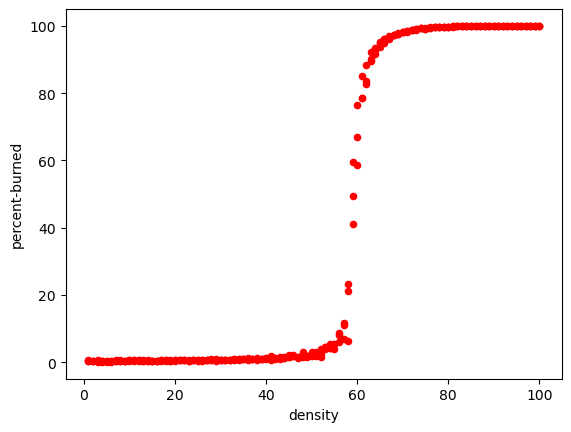

In [14]:
df.plot.scatter(x='density', y='percent-burned', color='red')

<Axes: >

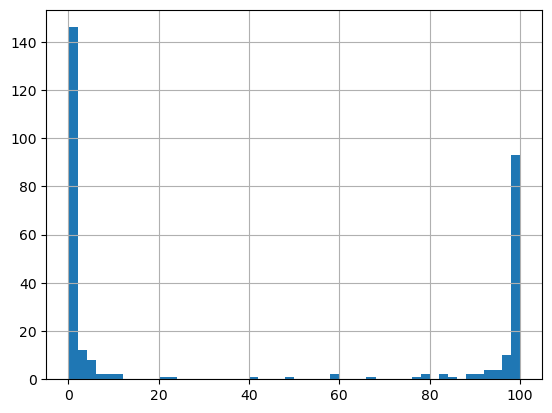

In [15]:
df['percent-burned'].hist(bins=50)